In [2]:
import RandomMatrix as RM
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import math
from TracyWidom import TracyWidom
from scipy.optimize import dual_annealing
import random

First we find best interpolant for many 2x2 GOEs

In [3]:
"""
Run MLE to find Beta
"""

# This function calculates \sum_{i=1}^n log f(\lambda_i | \beta)
def total_log_likelihood(beta, eigenvalues_list):
    """
    Computes the total log-likelihood for a list of eigenvalue arrays given beta and N.
    """
    total_ll = 0  # Total log-likelihood
    for eigenvalues in eigenvalues_list:
        cond_pdf_value = RM.gaussian_ensemble_density_N(eigenvalues, beta, len(eigenvalues))
        total_ll += np.log(cond_pdf_value)  # Sum the log-likelihoods
    return -total_ll  # Return the negative for minimization

Generate a dataset of 7 2x2 GOEs, so that \Lambda_i \in \mathbb{R}^2.

In [4]:
n = 2  # Size of the GOE ensembles
num_samples = 7  # Number of samples to generate
eigenvalues_list = []

# Generate 100 GOEs
for i in range(num_samples):
    m = RM.Generate_GOE(n)
    eigenvalues = np.linalg.eigh(m)[0]
    eigenvalues_list.append(eigenvalues)

print(len(eigenvalues_list))
print(eigenvalues_list)

7
[array([-1.90799346,  1.50878314]), array([-2.0510624 , -0.48715006]), array([-1.29499323,  0.35797112]), array([-0.7440785 ,  1.46688576]), array([0.86835273, 2.71840293]), array([0.07830072, 1.14009929]), array([-0.0280491,  1.364805 ])]


Graph the most likely PDF given the observed spectra

Estimated beta: 1.4633782618329843
Joint Density of Eigenvalues for Ensemble with β=~1.463


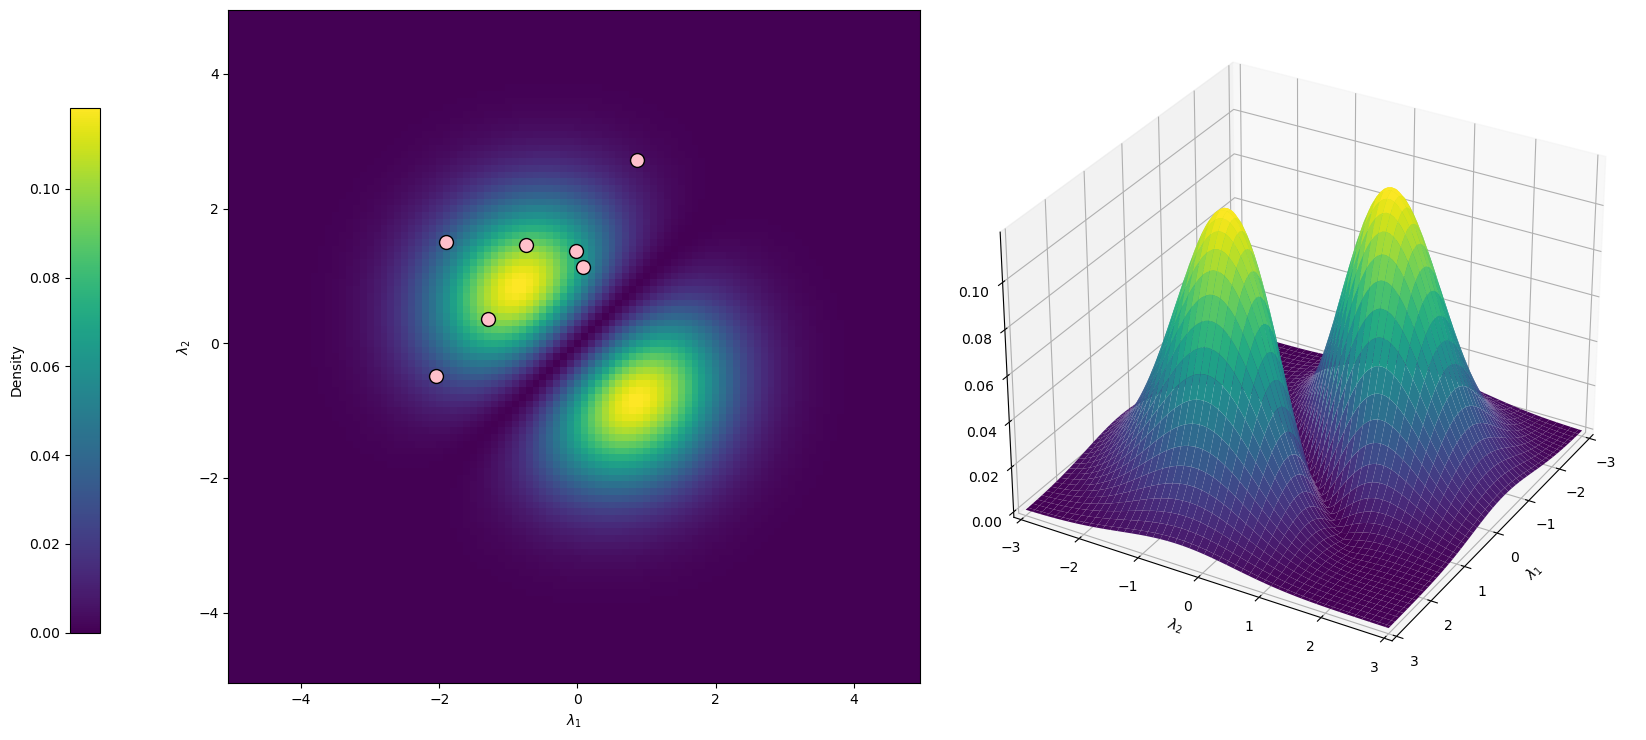

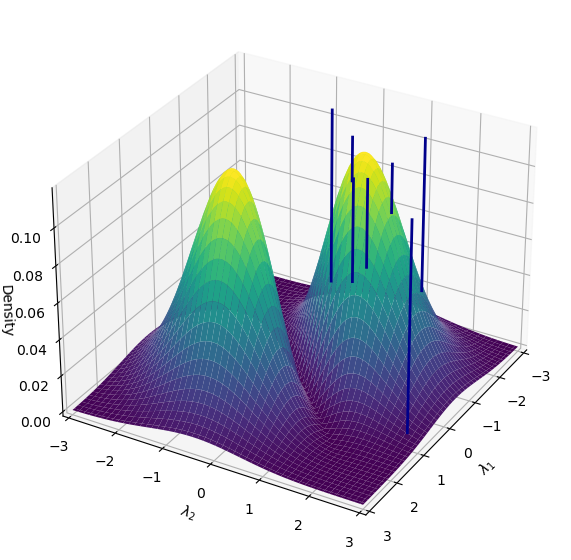

In [5]:
"""
Find best beta and graph the resulting PDF
"""

def optimize(func, initial_guess, eigenvalues_list):
    # Define the optimization
    bounds = [(0, None)]  # Beta must be positive

    result = minimize(
        fun=func,
        x0=initial_guess,
        args=(eigenvalues_list,),
        bounds=bounds,
        method='L-BFGS-B'
    )

    return result

initial_guess = [1.0]
best_beta = optimize(total_log_likelihood, initial_guess, eigenvalues_list).x[0]
print("Estimated beta:", best_beta)

def graph_2d():
    initial_guess = [0.0]
    best_beta_result = optimize(total_log_likelihood, initial_guess, eigenvalues_list)
    best_beta = best_beta_result.x[0]

    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    λ1, λ2 = np.meshgrid(x, y)
    Z = RM.joint_density(λ1, λ2, best_beta)

    plt.figure(figsize=(8, 6))

    plt.pcolormesh(λ1, λ2, Z, cmap=plt.cm.gnuplot2)
    cbar = plt.colorbar()
    cbar.set_label("Density")
    plt.title(f"Heatmap for Joint Density of Eigenvalues for Ensemble with Beta: ~{np.round(best_beta, 3)}")
    plt.xlabel("$\lambda_1$")
    plt.ylabel("$\lambda_2$")

    print(eigenvalues_list)
    for λ1_val, λ2_val in eigenvalues_list:
        plt.scatter(λ1_val, λ2_val, color='pink', edgecolor='black', zorder=5)
    
    # plt.savefig("joint_density_plot.png", dpi=1177, bbox_inches='tight')

    plt.show()

def graph_3d_with_lines_through_surface(best_beta, n, eigenvalues_list):
    beta = best_beta
    num_eigenvalues = n

    lambda1_range = np.linspace(-3, 3, 100)
    lambda2_range = np.linspace(-3, 3, 100)
    lambda1, lambda2 = np.meshgrid(lambda1_range, lambda2_range)

    # Initialize the density matrix
    density = np.zeros_like(lambda1)

    for i in range(lambda1.shape[0]):
        for j in range(lambda1.shape[1]):
            lambdas = np.array([lambda1[i, j], lambda2[i, j]])
            density[i, j] = RM.gaussian_ensemble_density(lambdas, beta)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(lambda1, lambda2, density, cmap='viridis', alpha=1)

    eigenvalues_array = np.array(eigenvalues_list)
    eigenvalues_density = [RM.gaussian_ensemble_density(point, beta) for point in eigenvalues_array]

    for x, y, z in zip(eigenvalues_array[:, 0], eigenvalues_array[:, 1], eigenvalues_density):
        ax.plot([x, x], [y, y], [z, np.max(density)], color='darkblue', linestyle='-', linewidth=2, zorder=150)

    ax.set_xlim([min(lambda1_range), max(lambda1_range)])
    ax.set_ylim([min(lambda2_range), max(lambda2_range)])
    ax.set_zlim([np.min(density), np.max(density)])

    ax.view_init(elev=30, azim=30)

    ax.set_xlabel('$\lambda_1$')
    ax.set_ylabel('$\lambda_2$')
    ax.set_zlabel('Density', labelpad=0)

    plt.show()

def graph_2d_and_3d(best_beta, n, eigenvalues_list):
    fig = plt.figure(figsize=(15, 7.5))

    # 2D plot
    ax1 = fig.add_subplot(121)
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    λ1, λ2 = np.meshgrid(x, y)
    Z = RM.joint_density(λ1, λ2, best_beta)

    pcm = ax1.pcolormesh(λ1, λ2, Z, cmap=plt.cm.viridis)
    ax1.set_xlabel("$\lambda_1$")
    ax1.set_ylabel("$\lambda_2$")

    for λ1_val, λ2_val in eigenvalues_list:
        ax1.scatter(λ1_val, λ2_val, color='pink', edgecolor='black', zorder=5, s=100)

    ax2 = fig.add_subplot(122, projection='3d')

    lambda1_range = np.linspace(-3, 3, 100)
    lambda2_range = np.linspace(-3, 3, 100)
    lambda1, lambda2 = np.meshgrid(lambda1_range, lambda2_range)

    # Initialize the density matrix
    density = np.zeros_like(lambda1)

    for i in range(lambda1.shape[0]):
        for j in range(lambda1.shape[1]):
            lambdas = np.array([lambda1[i, j], lambda2[i, j]])
            density[i, j] = RM.gaussian_ensemble_density(lambdas, best_beta)

    surf = ax2.plot_surface(lambda1, lambda2, density, cmap='viridis', alpha=1)

    ax2.set_xlim([min(lambda1_range), max(lambda1_range)])
    ax2.set_ylim([min(lambda2_range), max(lambda2_range)])
    ax2.set_zlim([np.min(density), np.max(density)])

    ax2.view_init(elev=30, azim=30)

    ax2.set_xlabel('$\lambda_1$')
    ax2.set_ylabel('$\lambda_2$')
    # ax2.set_zlabel('Density', labelpad=0)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)

    # Add a single colorbar for both subplots
    cbar_ax = fig.add_axes([-0.06, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(mappable=pcm, cax=cbar_ax)
    cbar = fig.colorbar(mappable=pcm, cax=cbar_ax, orientation='vertical', label="Density")

    cbar_ax.yaxis.set_label_position('left')
    cbar_ax.yaxis.set_ticks_position('left')
    cbar.set_label("Density")

    # fig.suptitle(f"Joint Density of Eigenvalues for Ensemble with β=~{np.round(best_beta, 3)}", y=1.07, fontsize=27)
    print(f"Joint Density of Eigenvalues for Ensemble with β=~{np.round(best_beta, 3)}")
    plt.savefig("finalENSEMB.png", dpi=377, bbox_inches='tight')

    plt.show()

graph_2d_and_3d(best_beta, n, eigenvalues_list)
graph_3d_with_lines_through_surface(best_beta, n, eigenvalues_list)

Now we build the mixture model that accounts for the TW-distributed largest eigenvalue of a GBE, and observe that it gives the same result as the classical model for small n. It is capable of recapitulating the correct Dyson index.

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 161.18095650958318
       x: [ 1.693e+00]
     nit: 1000
    nfev: 2005
    njev: 2
    nhev: 0
Joint Density of Eigenvalues for Ensemble with β=~1.693


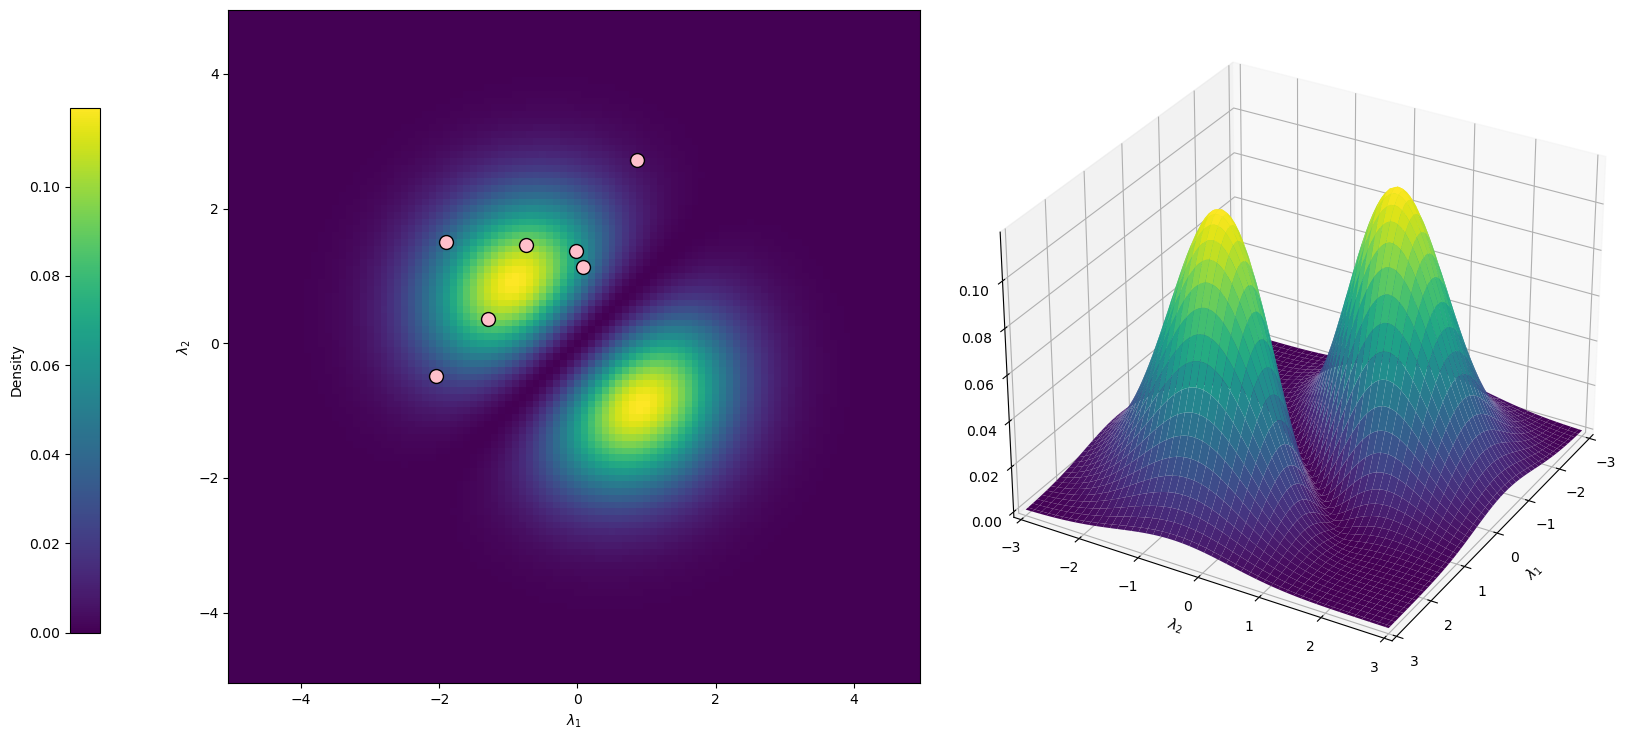

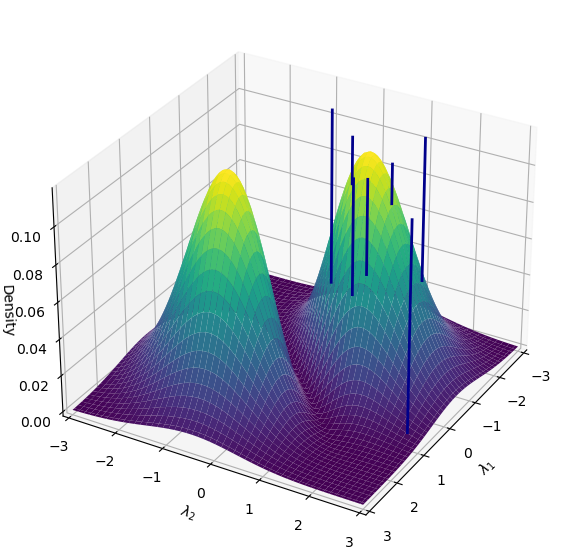

In [6]:
def callback_save_loss(params, loss_history):
    loss = mixture_model_likelihood(params, eigenvalues_list)
    loss_history.append(loss)
    print(f"Current loss: {loss}")

def mixture_model_likelihood(beta, eigenvalues_list):                
    total_ll = 0
    tw = TracyWidom(min([1, 2, 4], key=lambda x:abs(x-beta)))
    
    for eigenvalues in eigenvalues_list:
        gaussian_pdf_value = RM.gaussian_ensemble_density(eigenvalues, beta)
        TW_pdf_value = tw.pdf(((max(eigenvalues) - 2)/(n**(2/3))))
        
        sum = np.log(min(gaussian_pdf_value + TW_pdf_value, 1e-10))
        total_ll += (sum)

    return -total_ll

bounds= [(1,4)]
loss_history = []

# Run dual_annealing with the callback to save the loss
result = dual_annealing(mixture_model_likelihood, bounds, args=(eigenvalues_list,), maxiter=1000, callback=lambda x, f, context: callback_save_loss(x, loss_history))
print(result)
best_beta = result.x[0]
graph_2d_and_3d(best_beta, n, eigenvalues_list)
graph_3d_with_lines_through_surface(best_beta, n, eigenvalues_list)

In [7]:
def propose(current_state, sigma):
    return np.random.normal(current_state, sigma)

def metropolis_hastings(initial_state, beta, sigma, num_steps):
    state = initial_state
    states = [state]
    for _ in range(num_steps):
        candidate = propose(state, sigma)
        acceptance_prob = min(1, RM.gaussian_ensemble_density(candidate, beta) / RM.gaussian_ensemble_density(state, beta))
        if np.random.rand() < acceptance_prob:
            state = candidate
        states.append(state)
    return np.array(states)

# Parameters
beta = best_beta
num_steps = 100000
burn_in = int(num_steps * 0.1)
sigma = 0.0001

initial_state = np.random.normal(size=2)

states = metropolis_hastings(initial_state, beta, sigma, num_steps)

expected_lambdas = np.mean(states[burn_in:], axis=0)
print("Expected lambdas for GUE:", expected_lambdas)

Expected lambdas for GUE: [-0.16325338 -0.26114941]


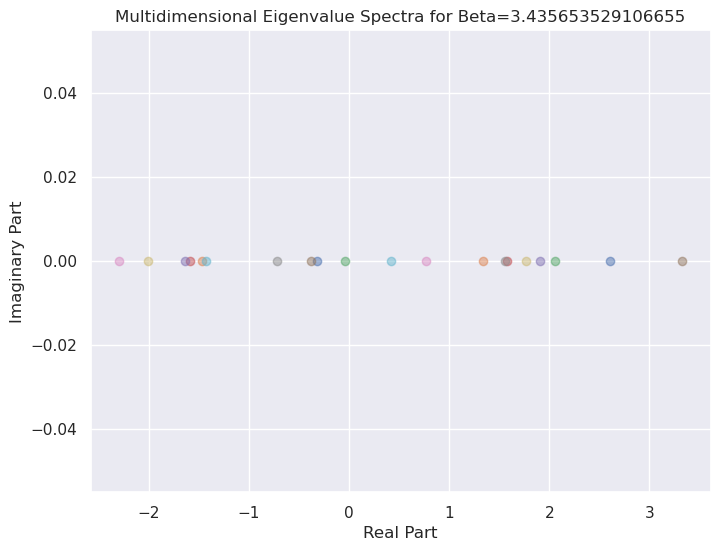

TypeError: graph_2d_and_3d() missing 1 required positional argument: 'eigenvalues_list'

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals

def graph_spectra(best_beta, num_matrices=10, n=2):
    matrices = [RM.Generate_Hermite(n, best_beta) for _ in range(num_matrices)]

    eigenvalue_spectra = [eigvals(matrix) for matrix in matrices]

    fig, ax = plt.subplots(figsize=(8, 6))

    for spectrum in eigenvalue_spectra:
        ax.scatter(np.real(spectrum), np.imag(spectrum), alpha=0.5)

    ax.set_title(f"Multidimensional Eigenvalue Spectra for Beta={best_beta}")
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    plt.show()

graph_spectra(best_beta)

Let us try a more difficult dataset of spectra, with 100x100 GOEs and 100x100 GUEs! Note that recapitulating the true Dyson index in a hyperdimensional PDF is not the motivation, but finding the best interpolant. That we discover the actual Dyson index is a consequence of having a large enough dataset, for which we converge on the true PDF. In general though, we can easily use this method to distinguish the Hermite classes of different sets of Gaussian ensembles.

In [9]:
n = 100
num_samples = 10
dataset_eigvals = []
for _ in range(num_samples):
    particle = RM.Generate_GOE(n)
    dataset_eigvals.append(np.linalg.eigh(particle)[0])

best_beta = None
best_alpha = None
best_loss = float('inf')

beta_values = [1, 2, 4]

best_beta = -float('inf')
for i in range(10):
    initial_guess = [random.uniform(0, 4)]

    result = dual_annealing(mixture_model_likelihood, bounds, args=(dataset_eigvals,), maxiter=100, callback=lambda x, f, context: callback_save_loss(x, loss_history))
    loss = result.fun
    if loss < best_loss:
        best_beta = result.x[0]
        best_loss = loss

print("Best beta for GOEs:", best_beta)


""" Now try with GUEs """

n = 100
num_samples = 10
dataset_eigvals = []
for _ in range(num_samples):
    particle = RM.Generate_GUE(n)
    dataset_eigvals.append(np.linalg.eigh(particle)[0])

best_beta = None
best_alpha = None
best_loss = float('inf')

beta_values = [1, 2, 4]

best_beta = -float('inf')
for i in range(10):
    initial_guess = [random.uniform(0, 4)]

    result = dual_annealing(mixture_model_likelihood, bounds, args=(dataset_eigvals,), maxiter=100, callback=lambda x, f, context: callback_save_loss(x, loss_history))
    loss = result.fun
    if loss < best_loss:
        best_beta = result.x[0]
        best_loss = loss

print("Best beta for GUEs:", best_beta)

/home/elonlit/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best beta for GOEs: 1.0028167750489905
Best beta for GUEs: 2.2768340127825115


To obtain the expected spectra from our reconstructed PDF, we use Metropolis Hastings.

In [10]:
def propose(current_state, sigma):
    return np.random.normal(current_state, sigma)

def metropolis_hastings(initial_state, beta, sigma, num_steps):
    state = initial_state
    states = [state]
    for _ in range(num_steps):
        candidate = propose(state, sigma)
        acceptance_prob = min(1, RM.gaussian_ensemble_density(candidate, beta) / RM.gaussian_ensemble_density(state, beta))
        if np.random.rand() < acceptance_prob:
            state = candidate
        states.append(state)
    return np.array(states)

# Parameters
beta = best_beta
num_steps = 100000
burn_in = int(num_steps * 0.1)
sigma = 0.0001

initial_state = np.random.normal(size=100)

states = metropolis_hastings(initial_state, beta, sigma, num_steps)

expected_lambdas = np.mean(states[burn_in:], axis=0)
print("Expected lambdas for GUE:", expected_lambdas)

/tmp/ipykernel_7725/3181052314.py:9: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_prob = min(1, RM.gaussian_ensemble_density(candidate, beta) / RM.gaussian_ensemble_density(state, beta))


Expected lambdas for GUE: [-1.3366033   1.26595775  0.86349858  0.55290338  0.46973751 -0.74857803
  0.74323331 -1.40218116 -1.24535963  3.62588143  1.15416857  0.50109314
 -0.99579924  1.94979382 -0.14160237  0.93143564  0.06956533  1.76129549
 -0.82912383  0.28388011 -1.54861507 -0.48129454  0.97659104  0.12929533
  0.60324867  0.60029544 -0.60027404  0.20802834  0.04841801  0.35112212
 -0.1507638   0.55275052 -0.45930644  0.12116131 -0.24787285 -1.19104683
  1.91840472  1.44580225 -1.18365474 -0.14408008  0.59359178 -0.52323261
 -1.18132233  0.41935984 -0.4354021   0.0557185   0.66787923  0.178765
  0.21409652 -0.97083746  1.93592177 -1.22932165 -0.04095388  0.34362809
  1.01891614  0.45072814 -0.99994077  2.29234771 -0.60514726 -1.55633909
  0.30665132  0.60739607  0.7091338  -0.29123691 -0.79246455  1.38658602
  0.74628281 -0.41509736 -1.85888152 -1.35221593 -1.00872328 -1.16462343
  0.379158   -0.96871097  0.34972236 -0.5149409   0.43777598 -0.22698525
 -0.99065043  1.17987159  1

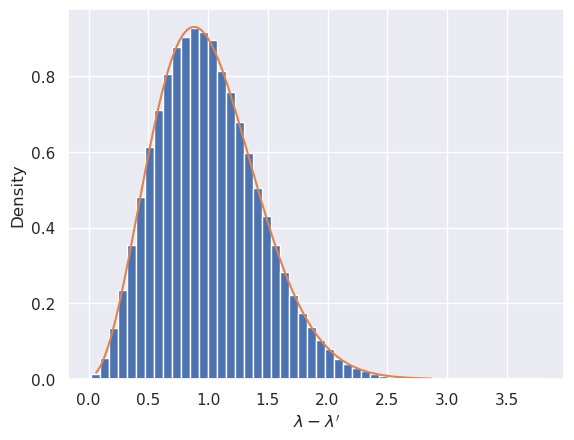

In [11]:
import numpy as np
from decimal import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.integrate import solve_ivp

import sys
import RandomMatrix as RM

%matplotlib inline
sns.set()

from math import pi
PI = Decimal(pi)

def f(t, y):
    σ = y[0]
    dσ = y[1]
    dy0 = dσ
    dy1 = -2/t * np.sqrt(max((σ-t*dσ)*(t*dσ - σ + (dσ)**2), 0))
    dy2 = σ/t
    return np.array([dy0, dy1, dy2])

t0 = 1e-15
tf = 9
y0_0 = -t0/np.pi-(t0/np.pi)**2
y0_1 = -1/np.pi-2*t0/np.pi
y0_2 = -t0/np.pi-t0**2/(2*pi**2)
y0 = np.array([y0_0, y0_1, y0_2])
sol = solve_ivp(f, (t0, tf) ,y0, max_step=.001)
σ = sol.y[0][100:]
dσ = sol.y[1][100:]
I = sol.y[2][100:]
t = sol.t[100:]
x = t/np.pi
E = np.exp(I)
p = E/x**2 * (σ**2 + x*np.pi*dσ - σ)

def normalize(λ1, λ2):
    # λ1 > λ2
    return (λ1 - λ2)*(np.sqrt(4*N-λ2**2)/(2*np.pi))

trials = 5000
Δs = []
N = 100
for _ in range(trials):
    A = RM.Generate_Hermite(N, 2) 
    λs, V = np.linalg.eigh(A)
    λs.sort()
    λs_middle = λs[round(N/4):round(3*N/4)]
    eig_spaces = [normalize(λs_middle[i+1], λs_middle[i]) for i in range(len(λs_middle)-1)]
    Δs.extend(eig_spaces)

plt.ylabel("Density")
plt.xlabel("$\lambda - \lambda'$")
plt.hist(Δs, bins=50, density=True)
plt.plot(x[100:], p[100:])

100000
(10000,)
Part 1: (3333,)
Part 2: (3333,)
Part 3: (3334,)


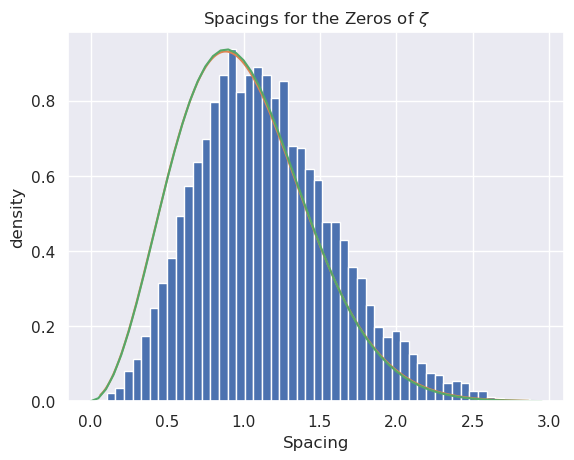

In [12]:
def get_diffs(γs):
    γ_bar = [γ * (γ/(2*PI)).ln()/(2*PI) for γ in γs]
    γ_diffs = np.diff(γ_bar)
    γ_diffs_fl = [float(γ) for γ in γ_diffs]
    return γ_diffs_fl

print(len(np.genfromtxt('zeros1.csv', delimiter=',')))
data = np.genfromtxt('zeros1.csv', delimiter=',')[:10000]

print(data.shape)

length = len(data)
part_length = length // 3

# Split the vector into three parts
data1 = data[:part_length]
data2 = data[part_length:2 * part_length]
data3 = data[2 * part_length:]

print("Part 1:", data1.shape)
print("Part 2:", data2.shape)
print("Part 3:", data3.shape)

γ1 = [Decimal(num) for num in data1]
γ1_bar = get_diffs(γ1)

γ2 = [Decimal(num) for num in data2]
γ2_bar = get_diffs(γ2)

γ3 = [Decimal(num) for num in data3]
γ3_bar = get_diffs(γ3)

Γ = γ1_bar.copy()
Γ.extend(γ2_bar)
Γ.extend(γ3_bar)

plt.title("Spacings for the Zeros of $\zeta$")
plt.ylabel("density")
plt.xlabel("Spacing")
plt.hist(Γ, bins=50, density=True)
plt.plot(x[100:], p[100:])

gamma = lambda x: scipy.special.gamma(x)
def wigner_surmise(s, beta):
    a = 2*(gamma((beta+2)/2))**(beta+1)/(gamma((beta+1)/2))**(beta + 2)
    b = (gamma((beta+2)/2))**2/(gamma((beta+1)/2))**2
    return a * (s**beta) * np.exp(-b*s**2)

t = np.arange(0., 3, 0.05)
wigner_curve = wigner_surmise(t, 2)
plt.plot(t, wigner_curve)

This is a little off! Now we will utilize bootstrapping to obtain a better estimate of the true Dyson index.

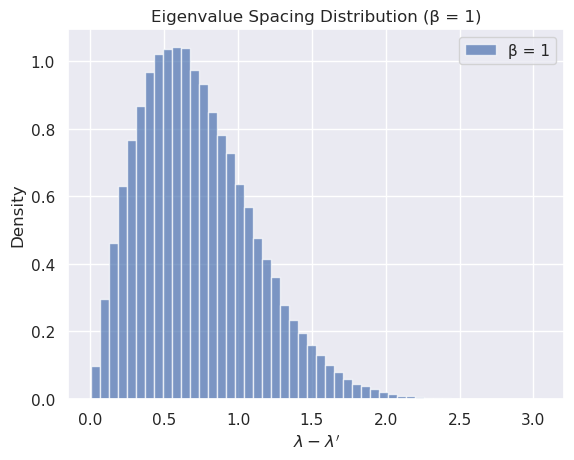

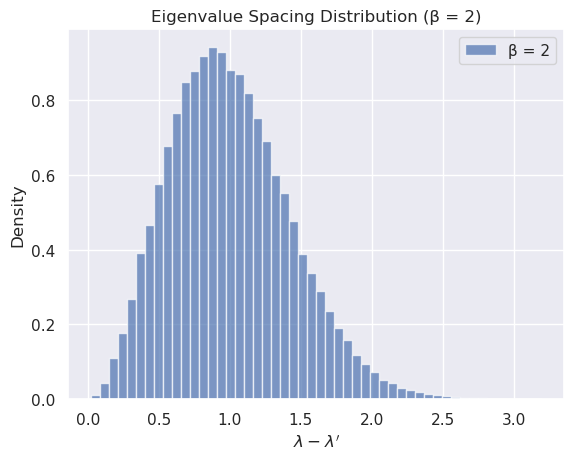

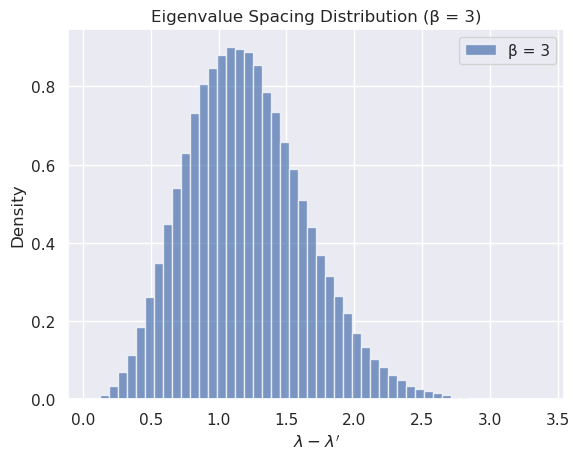

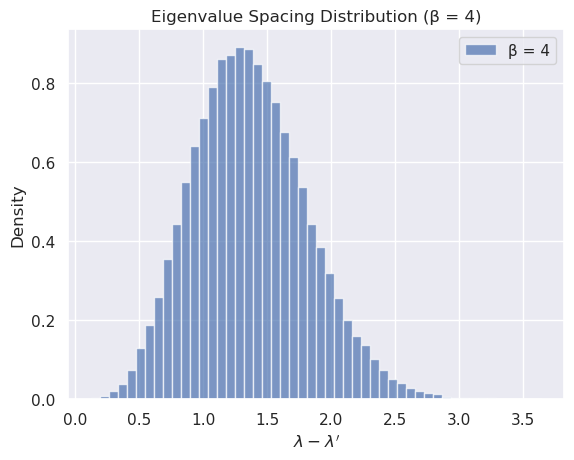

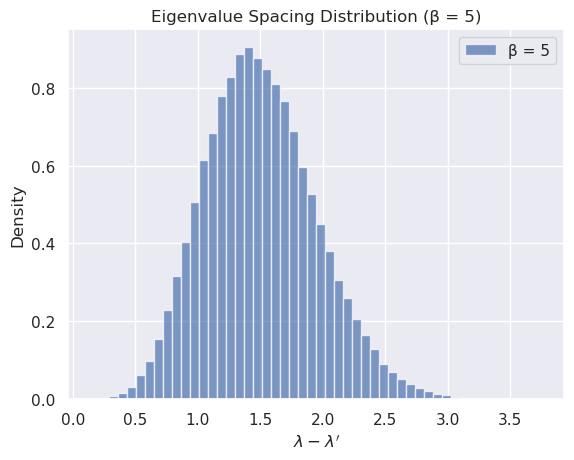

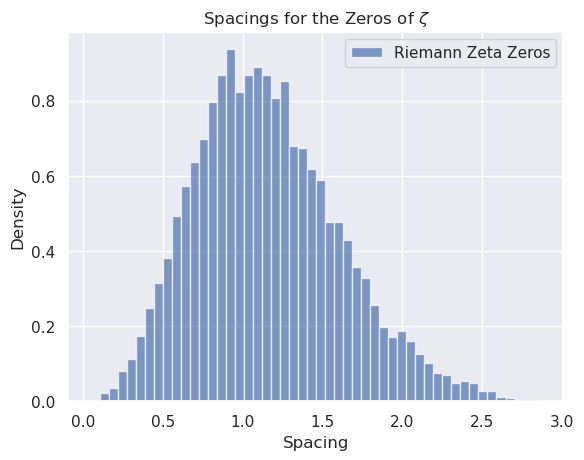

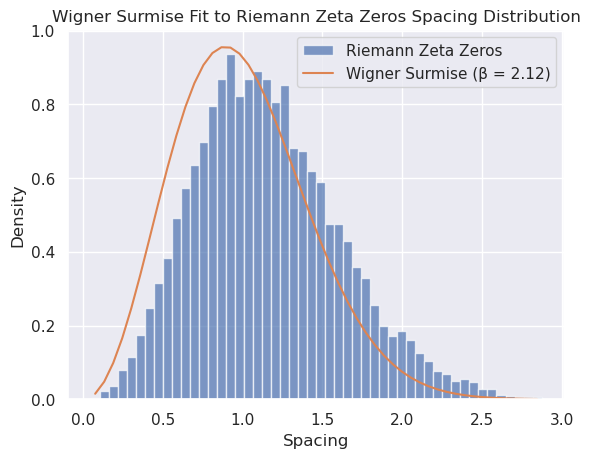

In [13]:
# Generate eigenvalue spacing distributions for different beta values

beta_values = [1 + x for x in range(0,5)]
for beta in beta_values:
    trials = 5000
    Δs = []
    N = 50
    for _ in range(trials):
        A = RM.Generate_Hermite(N, beta)
        λs, V = np.linalg.eigh(A)
        λs.sort()
        λs_middle = λs[round(N/4):round(3*N/4)]
        eig_spaces = [normalize(λs_middle[i+1], λs_middle[i]) for i in range(len(λs_middle)-1)]
        Δs.extend(eig_spaces)
    
    plt.figure()
    plt.ylabel("Density")
    plt.xlabel("$\lambda - \lambda'$")
    plt.title(f"Eigenvalue Spacing Distribution (β = {beta})")
    plt.hist(Δs, bins=50, density=True, alpha=0.7, label=f"β = {beta}")
    plt.legend()

# Plot the Riemann zeta zeros spacing distribution
plt.figure()
plt.title("Spacings for the Zeros of $\zeta$")
plt.ylabel("Density")
plt.xlabel("Spacing")
plt.hist(Γ, bins=50, density=True, alpha=0.7, label="Riemann Zeta Zeros")
plt.legend()

# Fit the Wigner surmise to the Riemann zeta zeros spacing distribution
t = np.arange(0., 3, 0.05)
best_beta = None
best_mse = float('inf')

hist, bin_edges = np.histogram(Γ, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for beta in np.arange(1, 4.1, 0.0001):
    wigner_curve = wigner_surmise(bin_centers, beta)
    mse = np.mean((hist - wigner_curve)**2)
    if mse < best_mse:
        best_beta = beta
        best_mse = mse

plt.figure()
plt.title("Wigner Surmise Fit to Riemann Zeta Zeros Spacing Distribution")
plt.ylabel("Density")
plt.xlabel("Spacing")
plt.hist(Γ, bins=50, density=True, alpha=0.7, label="Riemann Zeta Zeros")
plt.plot(bin_centers, wigner_surmise(bin_centers, best_beta), label=f"Wigner Surmise (β = {best_beta:.2f})")
plt.legend()

This seems to be a ghost random matrix over the first 10,000 zeros. Let's use bootstrapping and maintain an expanding window to obtain GBEs, which we will interpolate. We use low n, because Wigner's surmise is an approximation. This is totally arbitrary, and is due to the limitations of my hardware.

Basically:

For each window, obtain a portion of the zeta zeros. 

In [19]:
num_windows = 1000
GBE_list = []
N = 2
dataset = np.genfromtxt('zeros1.csv', delimiter=',')

# for i in range(num_windows, num_windows + 10000, 10000):
i = num_windows
while i < num_windows + 100000 or i<len(dataset):
    data = dataset[:i]

    print(data.shape)

    length = len(data)
    part_length = length // 3

    # Split the vector into three parts
    data1 = data[:part_length]
    data2 = data[part_length:2 * part_length]
    data3 = data[2 * part_length:]

    print("Part 1:", data1.shape)
    print("Part 2:", data2.shape)
    print("Part 3:", data3.shape)

    γ1 = [Decimal(num) for num in data1]
    γ1_bar = get_diffs(γ1)

    γ2 = [Decimal(num) for num in data2]
    γ2_bar = get_diffs(γ2)

    γ3 = [Decimal(num) for num in data3]
    γ3_bar = get_diffs(γ3)

    Γ = γ1_bar.copy()
    Γ.extend(γ2_bar)
    Γ.extend(γ3_bar)

    # beta_values = [1 + x for x in range(0,5)]
    # for beta in beta_values:
    #     trials = 1000
        # Δs = []
        # for _ in range(trials):
        #     A = RM.Generate_Hermite(N, beta)
        #     λs, V = np.linalg.eigh(A)
        #     λs.sort()
        #     λs_middle = λs[round(N/4):round(3*N/4)]
        #     eig_spaces = [normalize(λs_middle[i+1], λs_middle[i]) for i in range(len(λs_middle)-1)]
        #     Δs.extend(eig_spaces)

    # Fit the Wigner surmise to the Riemann zeta zeros spacing distribution
    t = np.arange(0., 3, 0.05)
    best_beta = None
    best_mse = float('inf')

    hist, bin_edges = np.histogram(Γ, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for beta in np.arange(1, 4.1, 0.0001):
        wigner_curve = wigner_surmise(bin_centers, beta)
        mse = np.mean((hist - wigner_curve)**2)
        if mse < best_mse:
            best_beta = beta
            best_mse = mse
    i += 1000
    GBE_list.append(best_beta)

print(GBE_list)

hermite_eigvals = []


for beta in GBE_list:
    num_steps = 10000
    burn_in = int(num_steps * 0.1)
    sigma = 0.1

    initial_state = np.random.normal(size=N)

    states = metropolis_hastings(initial_state, beta, sigma, num_steps)

    expected_lambdas = np.mean(states[burn_in:], axis=0)
    hermite_eigvals.append(np.array(expected_lambdas))
      

best_beta = None
best_alpha = None
best_loss = float('inf')

beta_values = [1, 2, 4]

best_beta = -float('inf')
for i in range(100):
    initial_guess = [random.uniform(0, 4)]

    result = dual_annealing(mixture_model_likelihood, bounds, args=(np.array(hermite_eigvals),), maxiter=100)
    loss = result.fun
    if loss < best_loss:
        best_beta = result.x[0]
        best_loss = loss

print("Best beta for Zeta Zeros:", best_beta)

(1000,)
Part 1: (333,)
Part 2: (333,)
Part 3: (334,)
(2000,)
Part 1: (666,)
Part 2: (666,)
Part 3: (668,)
(3000,)
Part 1: (1000,)
Part 2: (1000,)
Part 3: (1000,)
(4000,)
Part 1: (1333,)
Part 2: (1333,)
Part 3: (1334,)
(5000,)
Part 1: (1666,)
Part 2: (1666,)
Part 3: (1668,)
(6000,)
Part 1: (2000,)
Part 2: (2000,)
Part 3: (2000,)
(7000,)
Part 1: (2333,)
Part 2: (2333,)
Part 3: (2334,)
(8000,)
Part 1: (2666,)
Part 2: (2666,)
Part 3: (2668,)
(9000,)
Part 1: (3000,)
Part 2: (3000,)
Part 3: (3000,)
(10000,)
Part 1: (3333,)
Part 2: (3333,)
Part 3: (3334,)
(11000,)
Part 1: (3666,)
Part 2: (3666,)
Part 3: (3668,)
(12000,)
Part 1: (4000,)
Part 2: (4000,)
Part 3: (4000,)
(13000,)
Part 1: (4333,)
Part 2: (4333,)
Part 3: (4334,)
(14000,)
Part 1: (4666,)
Part 2: (4666,)
Part 3: (4668,)
(15000,)
Part 1: (5000,)
Part 2: (5000,)
Part 3: (5000,)
(16000,)
Part 1: (5333,)
Part 2: (5333,)
Part 3: (5334,)
(17000,)
Part 1: (5666,)
Part 2: (5666,)
Part 3: (5668,)
(18000,)
Part 1: (6000,)
Part 2: (6000,)
Part 

In [20]:
lst1 = [2.045099999999885, 2.107199999999878, 2.0961999999998793, 2.1116999999998773, 2.124899999999876, 2.1284999999998755, 2.123999999999876, 2.116399999999877, 2.120699999999877, 2.119899999999877, 2.116099999999877, 2.124899999999876, 2.1246999999998764, 2.118599999999877, 2.1213999999998765, 2.1215999999998765, 2.114899999999877, 2.116399999999877, 2.1230999999998765, 2.118599999999877, 2.1196999999998765, 2.123299999999876, 2.1250999999998763, 2.124399999999876, 2.125299999999876, 2.1214999999998767, 2.1189999999998768, 2.1212999999998763, 2.122499999999876, 2.124499999999876, 2.1218999999998767, 2.122899999999876, 2.124399999999876, 2.1216999999998762, 2.1208999999998763, 2.1211999999998765, 2.1210999999998768, 2.119099999999877, 2.117799999999877, 2.115999999999877, 2.114899999999877, 2.1138999999998775, 2.1135999999998774, 2.1135999999998774, 2.115199999999877, 2.114899999999877, 2.1097999999998778, 2.1108999999998774, 2.1104999999998775, 2.109499999999878, 2.1113999999998776, 2.109199999999878, 2.108799999999878, 2.1092999999998776, 2.1107999999998777, 2.109499999999878, 2.107299999999878, 2.107599999999878, 2.107999999999878, 2.107799999999878, 2.1084999999998777, 2.1113999999998776, 2.1108999999998774, 2.109599999999878, 2.108599999999878, 2.107799999999878, 2.106799999999878, 2.1066999999998783, 2.1070999999998783, 2.106799999999878, 2.107199999999878, 2.105799999999878, 2.106099999999878, 2.1066999999998783, 2.107299999999878, 2.1049999999998783, 2.1049999999998783, 2.1049999999998783, 2.1042999999998786, 2.1046999999998786, 2.1054999999998785, 2.1034999999998787, 2.107299999999878, 2.105999999999878, 2.1053999999998783, 2.1053999999998783, 2.1054999999998785, 2.104499999999878, 2.1046999999998786, 2.1054999999998785, 2.1054999999998785, 2.106099999999878, 2.105299999999878, 2.105699999999878, 2.106199999999878, 2.1030999999998787, 2.1026999999998788, 2.102299999999879, 2.1021999999998786, 2.1019999999998786]
lst2 = [2.045099999999885, 2.107199999999878, 2.0961999999998793, 2.1116999999998773, 2.124899999999876, 2.1284999999998755, 2.123999999999876, 2.116399999999877, 2.120699999999877, 2.119899999999877, 2.116099999999877, 2.124899999999876, 2.1246999999998764, 2.118599999999877, 2.1213999999998765, 2.1215999999998765, 2.114899999999877, 2.116399999999877, 2.1230999999998765, 2.118599999999877, 2.1196999999998765, 2.123299999999876, 2.1250999999998763, 2.124399999999876, 2.125299999999876, 2.1214999999998767, 2.1189999999998768, 2.1212999999998763, 2.122499999999876, 2.124499999999876, 2.1218999999998767, 2.122899999999876, 2.124399999999876, 2.1216999999998762, 2.1208999999998763, 2.1211999999998765, 2.1210999999998768, 2.119099999999877, 2.117799999999877, 2.115999999999877, 2.114899999999877, 2.1138999999998775, 2.1135999999998774, 2.1135999999998774, 2.115199999999877, 2.114899999999877, 2.1097999999998778, 2.1108999999998774, 2.1104999999998775, 2.109499999999878, 2.1113999999998776, 2.109199999999878, 2.108799999999878, 2.1092999999998776, 2.1107999999998777, 2.109499999999878, 2.107299999999878, 2.107599999999878, 2.107999999999878, 2.107799999999878, 2.1084999999998777, 2.1113999999998776, 2.1108999999998774, 2.109599999999878, 2.108599999999878, 2.107799999999878, 2.106799999999878, 2.1066999999998783, 2.1070999999998783, 2.106799999999878, 2.107199999999878, 2.105799999999878, 2.106099999999878, 2.1066999999998783, 2.107299999999878, 2.1049999999998783, 2.1049999999998783, 2.1049999999998783, 2.1042999999998786, 2.1046999999998786, 2.1054999999998785, 2.1034999999998787, 2.107299999999878, 2.105999999999878, 2.1053999999998783, 2.1053999999998783, 2.1054999999998785, 2.104499999999878, 2.1046999999998786, 2.1054999999998785, 2.1054999999998785, 2.106099999999878, 2.105299999999878, 2.105699999999878, 2.106199999999878, 2.1030999999998787, 2.1026999999998788, 2.102299999999879, 2.1021999999998786, 2.1019999999998786]

print(sum(lst2)/len(lst2))

2.1118069999998776


[array([-1.90799346,  1.50878314]), array([-2.0510624 , -0.48715006]), array([-1.29499323,  0.35797112]), array([-0.7440785 ,  1.46688576]), array([0.86835273, 2.71840293]), array([0.07830072, 1.14009929]), array([-0.0280491,  1.364805 ])]


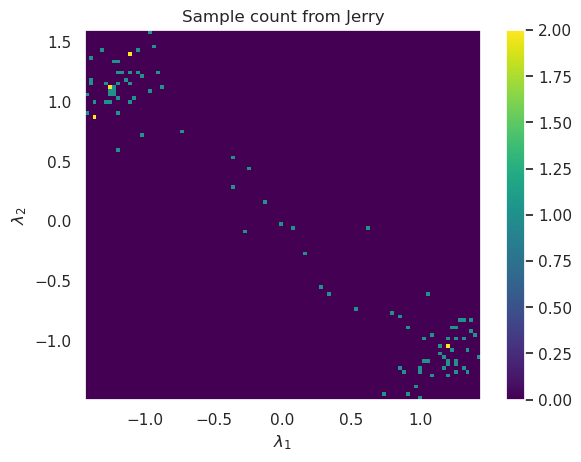

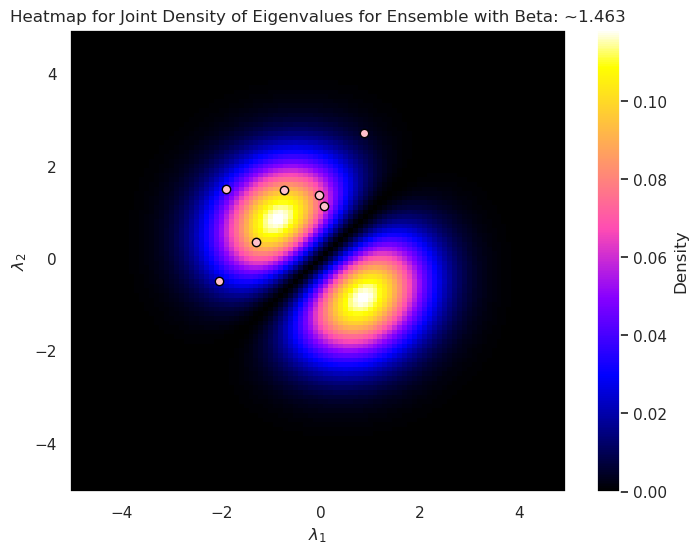

Joint Density of Eigenvalues for Ensemble with β=~3.436


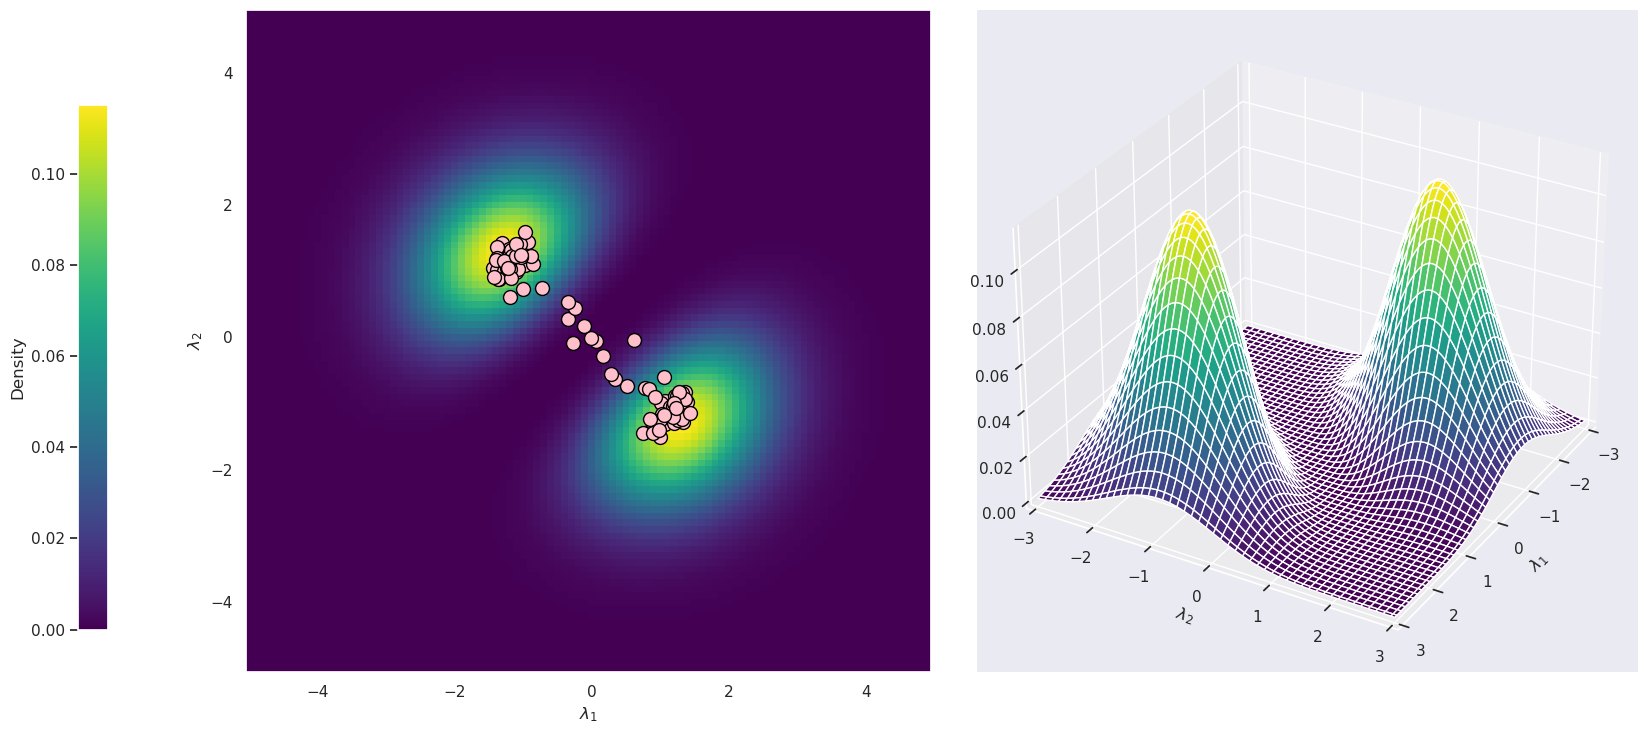

In [42]:
λ0 = []
λ1 = []
for eigval in hermite_eigvals:
    λs = eigval

    # Drop complex eigvals
    if not np.any(np.iscomplex(λs)):
        λ0.append(λs[0].real)
        λ1.append(λs[1].real)

plt.xlabel("$\lambda_1$")
plt.ylabel("$\lambda_2$")
plt.title("Sample count from Jerry")
plt.hist2d(λ0, λ1, bins=100, cmap=plt.cm.viridis)
plt.savefig("jerry.png", dpi=377, bbox_inches='tight')
plt.colorbar()

graph_2d()
graph_2d_and_3d(best_beta, 2, hermite_eigvals)